In [1]:
import sys
import os
from pathlib import Path
import math
import awkward as ak
import numpy as np
import uproot
import boost_histogram as bh
import hist
from hist import Hist, intervals, axis
import matplotlib.pyplot as plt
from matplotlib import cycler
import mplhep as hep
from coffea import nanoevents, lookup_tools
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.nanoevents.methods import vector, candidate, nanoaod
from coffea.nanoevents.methods.vector import PtEtaPhiELorentzVector
from coffea.lookup_tools import extractor, evaluator
from coffea.analysis_tools import PackedSelection
import dask
from dask import delayed
from dask.distributed import Client
from dask_jobqueue import HTCondorCluster


In [2]:
MAX_WORKERS = 40
CHUNKSIZE = 20_000
MAX_CHUNKS = None

In [3]:
@delayed(pure=True)
def get_tree(url):    
    return uproot.open(url)["Events"]

In [4]:
redirector = "root://cmsxrootd.fnal.gov//store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"
#redirector17D = "/hdfs/store/user/cgalloni/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23"

mt_fileset = {
    "DYJets": [
        redirector+f"/2018/MC/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/231225_151806/0000/NANO_NANO_{i}.root"
        for i in range(1,10)
    ],
    "WJets": [
        redirector+f"/2018/MC/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/231225_151948/0000/NANO_NANO_{i}.root"
        for i in range(1,10)
    ],
    "TT": [
        redirector+f"/2018/MC/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/240203_190026/0000/NANO_NANO_1.root"#{i}.root"
        for i in range(1,10) #leptonic
    ],  
    "VV": [
        redirector+f"/2018/MC/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/WZTo1L1Nu2Q_4f_TuneCP5_13TeV-amcatnloFXFX-pythia8/231225_152904/0000/NANO_NANO_1.root"#{i}.root"
        for i in range(1,10)
    ],
    "Data": [
        redirector+f"/2018/MC/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/231225_152455/0000/NANO_NANO_{i}.root"
        for i in range(1,5) #fix get real data
    ]
}
inputs = []
for label in mt_fileset:
    input = [get_tree(url) for url in mt_fileset[label]]
    inputs = np.append(inputs, input)
inputs

array([Delayed('get_tree-06e55f2d7e1415ab82d5f3147117c344'),
       Delayed('get_tree-2cd70fc345008314b60dc5cf836124c7'),
       Delayed('get_tree-2547e5ca6420f9af750da5194c654aa1'),
       Delayed('get_tree-558f8443f61aaaa54ae2de9c00c55ee4'),
       Delayed('get_tree-434196afba906140963f11f96ea7558b'),
       Delayed('get_tree-b6d38073802da88922888a70f93cfb54'),
       Delayed('get_tree-bc44f581d095980d99b10ab8cab666ce'),
       Delayed('get_tree-b0db098aa37d23b970356d295eacd8f9'),
       Delayed('get_tree-b3146c1ea314c70c321dd9e5c031a67e'),
       Delayed('get_tree-9208a7c04d6e1bcb9c7043f5f1dbdf3b'),
       Delayed('get_tree-00dfaf0f87ec13df79a5ea10a76bbd76'),
       Delayed('get_tree-90bb75bc945e41cfd9364de998ed24a1'),
       Delayed('get_tree-3c12b4a1aed7ec64658ae7a4a962e869'),
       Delayed('get_tree-11d82d4b1bc86677257f2d27f73e8725'),
       Delayed('get_tree-d2fd496ed380307c7f2929343d6427b8'),
       Delayed('get_tree-eca157fbe2b0062579b0e10cded82842'),
       Delayed('get_tree

In [5]:
def bit_mask(bit):
      mask = 0
      mask += (1 << bit)
      return mask

In [6]:
def weightCalc(name):
      WScaleFactor = 1.21
      TT_FulLep_BR= 0.1061
      TT_SemiLep_BR= 0.4392
      TT_Had_BR= 0.4544

      if "Radion" in name: return 1
      elif "DYJets" in name:
         if "50To100" in name: return 387.130778
         elif "100To250" in name: return 89.395097
         elif "250To400" in name: return 3.435181
         elif "400To650" in name: return 0.464024
         elif "650ToInf" in name: return 0.043602
         elif "100to200" in name: return 160.7
         elif "200to400" in name: return 48.63
         elif "400to600" in name: return 6.993
         elif "600to800" in name: return 1.761
         elif "800to1200" in name: return .8021
         elif "1200to2500" in name: return .1937
         elif "2500toInf" in name: return .003514
      elif "WJets" in name:
         if "100To200" in name: return 1256
         elif "70To100" in name: return 1264
         elif "200To400" in name: return 335.5
         elif "400To600" in name: return 45.25
         elif "600To800" in name: return 91.16
         elif "800To1200" in name: return 4.933
         elif "1200To2500" in name: return 1.16
         elif "2500ToInf" in name: return 0.008001 
      elif "QCD" in name:
         if "300to500" in name: return 347700
         elif "500to700" in name: return 32100
         elif "700to1000" in name: return 6831
         elif "1000to1500" in name: return 1207
         elif "1500to2000" in name: return 119.9
         elif "2000toInf" in name: return 25.24
      elif "ggH125" in name: return 48.30 * 0.0621
      elif "ggZHLL125" in name: return 0.1223 * 0.062 * 3 * 0.033658
      elif "ggZHNuNu125" in name: return 0.1223 * 0.062 * 0.2000
      elif "ggZHQQ125" in name: return 0.1223 * 0.062 * 0.6991
      elif "JJH0" in name:
         if "OneJet" in name: return 0.1383997884
         elif "TwoJet" in name: return 0.2270577971
         elif "ZeroJet" in name: return 0.3989964912
      elif "qqH125" in name: return 3.770 * 0.0621
      elif "Tbar-tchan" in name: return  26.23
      elif "Tbar-tW" in name: return 35.6
      elif "toptopH125" in name: return 0.5033 * 0.062
      elif "T-tchan.root" in name: return 44.07
      elif "T-tW" in name: return 35.6
      elif "TTT" in name:
         if "2L2Nu" in name: return 87.31
         if "Hadronic" in name: return 378.93
         if "SemiLeptonic" in name: return 364.35
      elif "VV2l2nu" in name: return 11.95
      elif "WMinus" in name: return 0.5272 * 0.0621
      elif "WPlus" in name: return 0.8331 * 0.0621
      elif "WZ" in name:
         if "1L1Nu" in name: return 10.71
         elif "1L3Nu" in name: return 3.05
         elif "2Q2L" in name: return 6.419
      elif "WWTo1L1Nu" in name: return 49.997
      elif "ZH125" in name: return 0.7544 * 0.0621
      elif "ZZTo2Q2L" in name: return 3.22
      elif "ZZTo4L" in name: return 1.325
      elif "ZZTo2Nu2Q" in name: return 4.04
      elif "RadionTohhTohtatahbb_narrow_M" in name:
         if "1000" in name: return
         elif "1000" in name: return 1
         elif "1200" in name: return 1
         elif "1400" in name: return 1
         elif "1600" in name: return 1
         elif "1800" in name: return 1
         elif "2000" in name: return 1
         elif "2500" in name: return 1
         elif "3000" in name: return 1
         elif "3500" in name: return 1
         elif "4000" in name: return 1
         elif "4500" in name: return 1
      elif "ST_t-channel" in name:
         if "4f_leptonDecays" in name: return 3.549
         elif "antitop_4f_InclusiveDecays" in name: return 69.09
         elif "top_4f_InclusiveDecays" in name: return 115.3
         elif "antitop_5f_inclusiveDecays" in name: return 34.97
         elif "top_5f_inclusiveDecays" in name: return 34.91
      else: print("Something's Wrong!")
      return 1.01

In [7]:
   with uproot.open("pu_distributions_mc_2018.root") as f1:
      with uproot.open("pu_distributions_data_2018.root") as f2:
         mc = f1["pileup"].values()
         data = f2["pileup"].values()
         HistoPUMC = np.divide(mc, ak.sum(mc))
         HistoPUData = np.divide(data, ak.sum(data))
         PUWeight = np.divide(HistoPUData, HistoPUMC)

/tmp/ipykernel_2824159/1460999151.py:7: RuntimeWarning: divide by zero encountered in divide
  PUWeight = np.divide(HistoPUData, HistoPUMC)


In [81]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        ak.behavior.update(nanoaod.behavior)
        self._accumulator = {}
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self,events):
        dataset = events.metadata["dataset"]

        selection = PackedSelection()
        
        name = str(events.metadata["filename"])
        XSection = weightCalc(name)

        electron = events.Electron
        ele_cut = (electron.pt >= 15) & (np.abs(electron.eta) <= 2.5)
        lowMVAele = electron[(np.abs(electron.eta) <= 0.8) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.83)
        midMVAele = electron[(np.abs(electron.eta) > 0.8) & (np.abs(electron.eta) <= 1.5) & (electron.mvaIso_WPL) & ele_cut] #electron.mvaFall17V2Iso > -0.77
        highMVAele = electron[(np.abs(electron.eta) >= 1.5) & (electron.mvaIso_WPL) & ele_cut] # (electron.mvaFall17V2Iso > -0.69)

        #selection.add("ExtraEleVeto", ((ak.num(lowMVAele) == 0) & (ak.num(midMVAele) == 0) & (ak.num(highMVAele) == 0)))
        events = events[((ak.num(lowMVAele) == 0) & (ak.num(midMVAele) == 0) & (ak.num(highMVAele) == 0))]
       
        #Extra muon veto
        muon = events.Muon
        muon = muon[ak.num(muon) > 1]
        badMuon = muon[(np.abs(muon.pfRelIso04_all) > 0.3) & (muon[:,1].pt > 10) & (muon.tightId)] #tightId instead of bitwise thing

        #selection.add("ExtraMuVeto", ((ak.num(muon) > 0) & (ak.num(badMuon) == 0)))
        events = events[((ak.num(muon) > 0) & (ak.num(badMuon) == 0))]

        
        #BJets
        jets = events.Jet
        events["goodJets"]= jets[(jets.jetId > 0.5) & (jets.pt > 30) & (np.abs(jets.eta) < 3.0)]
        events["HT"] = ak.sum(events.goodJets.pt, axis=-1)

        #BJet Veto 
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! change btagdeepflavb for each year https://btv-wiki.docs.cern.ch/ScaleFactors/UL2018/
        events["bJets"] = events.Jet[(jets.btagDeepFlavB > .7100) & (jets.jetId > .5) & (jets.pt > 30) & (np.abs(jets.eta) < 2.4)]

        selection.add("BJetVeto", (ak.num(jets) > 0) & (events.HT > 200) & (ak.num(events.bJets) == 0))
        print((ak.num(jets) > 0) & (events.HT > 200) & (ak.num(events.bJets) == 0))
        selection.add("MuTau", (ak.num(events.Muon) > 0) & (ak.num(events.boostedTau) > 0))


        

        selection.add("HLT27", (events.HLT.Mu27)) #& (events.Muon.pt >= 27) & (events.Muon.pt < 52) & (events.Muon.pfRelIso04_all <= .3) & (events.MET.pt < 2.3))
        selection.add("HLT50", (events.HLT.Mu50)) #& (events.Muon.pt >= 52))
        print(events.HLT.Mu50)
        #dr = events['boostedTau'].delta_r(events.Muon)

        events["pairs"] = ak.cartesian({'tau': events.boostedTau, 'muon': events.Muon}, nested=False)

        pairSelection = PackedSelection()
        
        #ID Cut
       # events["MuID"] = (events.Muon.tightId) # & (np.abs(pairsC['muon'].dxy) < 0.045)
        
        mu_mask = ((events.pairs.muon.eta < 2.4) & (np.abs(events.pairs.muon.dz) < 0.2) & events.pairs.muon.tightId)
        tau_mask = ((events.pairs.tau.pt > 30)
              & (np.absolute(events.pairs.tau.eta) < 2.3)
              & (events.pairs.tau.idAntiMu > 0)
              & (events.pairs.tau.idDecayModeOldDMs))
             # & (dr > .1) 
             # & (dr < .8))
        print(mu_mask)
        pairSelection.add("GoodMu", mu_mask)
        pairSelection.add("GoodTau", tau_mask)


        events["tmass"] = np.sqrt(np.square(events.pairs.muon.pt + events.MET.pt) - np.square(events.pairs.muon.px + events.MET.pt * np.cos(events.MET.phi)) - np.square(events.pairs.muon.py + events.MET.pt * np.sin(events.MET.phi)))
        pairSelection.add("tmass_cut", events.tmass < 80)
        
        events["OS"] = events.pairs.muon.charge + events.pairs.tau.charge == 0
        pairsSelection.add("OS", events["OS"])
            

        
        regions = {
        "HLT50": {"ExtraEleVeto": True, "ExtraMuVeto": True, "BJetVeto": True, "MuTau": True, "HLT27": False, "HLT50": True, "GoodMu": True, "GoodTau": True, "tmass_cut": True, "OS": True},
        "HLT27": {"ExtraEleVeto": True, "ExtraMuVeto": True, "BJetVeto": True, "MuTau": True, "HLT27": True, "HLT50": False, "GoodMu": True, "GoodTau": True, "tmass_cut": True, "OS": True},
        }

        pairRegions = {
        "OS": {"GoodMu": True, "GoodTau": True, "tmass_cut": True, "OS": True},
        "SS": {"GoodMu": True, "GoodTau": True, "tmass_cut": True, "OS": False},
        }


        masshist = (
        Hist.new
        .StrCat(sign_regions.keys(), name="Sign/Trigger Region")
        #.StrCat(["nominal"] + list(weights.variations), name="systematic")
        .Reg(30, 0, 150, flow=False, name="mass", label=dataset)
        .Weight()
        )

            
        output = {}
        output[dataset] =  {
            "Test": processor.value_accumulator(int),
            "mass": masshist,
            "EventCount": processor.value_accumulator(int),
            }
        eventCount = len(events)
        

        for region, cuts in regions.items():
            goodevent = selection.require(**cuts)
            gEvents = events[goodevent]
            
            MetVec =  ak.zip(
                {
                 "pt": gEvents.MET.pt,
                 "eta": 0,
                 "phi": gEvents.MET.phi,
                 "mass": 0,
                 },
                with_name="PtEtaPhiMLorentzVector",
                behavior=vector.behavior,
            ) 
            Zmt_pt = pairs.tau.pt + pairs.muon.pt
            Higgs_pt = Zmt_pt + MetVec.pt
            
            gEvents = gEvents[Zmt_pt > 200 & Higgs_pt > 250]

            Zmt = gEvents.pairs.tau.mass + gEvents.pairs.muon.mass
            Z_mass = ak.flatten(Zmt, axis=1)
                                
            
            
        output[dataset]["EventCount"] += eventCount
        output[dataset]["mass"].fill(mass=Z_mass)#, weight=mass_w)
        output[dataset]["Test"] += 1
       
        return output
        
    def postprocess(self, accumulator):
        return accumulator


In [9]:
os.environ["CONDOR_CONFIG"] = "/etc/condor/condor_config"

try:
    _x509_localpath = (
        [
            line
            for line in os.popen("voms-proxy-info").read().split("\n")
            if line.startswith("path")
        ][0]
        .split(":")[-1]
        .strip()
    )
except Exception as err:
    raise RuntimeError(
        "x509 proxy could not be parsed, try creating it with 'voms-proxy-init'"
    ) from err
_x509_path = f'/scratch/{os.environ["USER"]}/{_x509_localpath.split("/")[-1]}'
os.system(f"cp {_x509_localpath} {_x509_path}")
_x509_path = os.path.basename(_x509_localpath)

In [10]:
PWD = os.getcwd()
print(f'Transferring contents of {PWD} to workers')
INITIAL_DIR = f'/scratch/{os.environ["USER"]}'
cluster = HTCondorCluster(
    cores=4,
    memory="4 GB",
    disk="8 GB",
    death_timeout = '120',
    job_extra_directives={
        "+JobFlavour": '"tomorrow"',
        "log": "dask_job_output.$(PROCESS).$(CLUSTER).log",
        "output": "dask_job_output.$(PROCESS).$(CLUSTER).out",
        "error": "dask_job_output.$(PROCESS).$(CLUSTER).err",
        "should_transfer_files": "yes",
        "when_to_transfer_output": "ON_EXIT_OR_EVICT",
        "+SingularityImage": '"/cvmfs/unpacked.cern.ch/registry.hub.docker.com/coffeateam/coffea-dask:0.7.22-py3.10-g7cbcc"',
        "Requirements": "HasSingularityJobStart",
        "InitialDir": INITIAL_DIR,
        "transfer_input_files": f'{_x509_path}'
        #"use_x509userproxy": "true",
    },
    job_script_prologue=[
        "export XRD_RUNFORKHANDLER=1",
        f"export X509_USER_PROXY={_x509_path}",
    ]
)
print('Condor logs, output files, error files in {}'.format(INITIAL_DIR))
cluster.adapt(minimum=10, maximum=MAX_WORKERS)
client = Client(cluster)
dask_executor = processor.DaskExecutor(client=client, status=True)
print("Executor created")

client

Transferring contents of /afs/hep.wisc.edu/user/emettner/rootProjects/Radion-DiHiggs-4Tau/NanoRun to workers
Condor logs, output files, error files in /scratch/emettner
Executor created


Connection method: Cluster object,Cluster type: dask_jobqueue.HTCondorCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://144.92.181.248:21159,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [31]:
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=dask_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=300,
)

Creating runner
Using chunksize: 20000 and maxchunks None


NameError: name 'dask_executor' is not defined

In [32]:
print("Calling runner")
mt_results_dask = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Calling runner


NameError: name 'runner' is not defined

In [103]:
client.shutdown()

In [15]:
for dset,results, in mt_results_dask.items():
    #print(f"Dataset: {dset}")
    #print(f"Test: {results['Test'].value}")
    #print(f"Event: {results['EventCount'].value}")
    #print(results["mass"])

SyntaxError: incomplete input (1824644622.py, line 5)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb35b162380>, errorbar=None, legend_artist=None)]

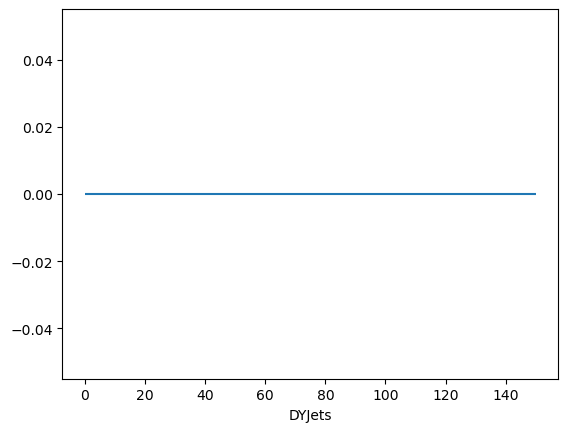

In [16]:
mt_results_dask["DYJets"]["mass"].plot()

In [82]:
local_executor = processor.IterativeExecutor(status=True)

#Create the runner
print("Creating runner")
print("Using chunksize: {} and maxchunks {}".format(CHUNKSIZE,MAX_CHUNKS))
runner = processor.Runner(
    executor=local_executor,
    schema=NanoAODSchema,
    chunksize=CHUNKSIZE,
    maxchunks=MAX_CHUNKS,
    skipbadfiles=True,
    xrootdtimeout=120,
)

Creating runner
Using chunksize: 20000 and maxchunks None


In [83]:
print("Calling runner")
mt_results_local = runner(
    mt_fileset,
    treename="Events",
    processor_instance=MyProcessor(),
)

Output()

Calling runner


[False, False, True, False, False, False, ... True, True, False, True, False, False]

[True, False, False, False, False, False, ... True, True, True, False, False, False]

[[False, True, False, False, False, False, ... [False, False, False, False]]

Exception: Failed processing file: WorkItem(dataset='Data', filename='root://cmsxrootd.fnal.gov//store/user/gparida/HHbbtt/Full_Production_CMSSW_13_0_13_Nov24_23/2018/MC/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/RadionTohhTohtatahbb_narrow_M-2000_TuneCP5_13TeV-madgraph-pythia8/231225_152455/0000/NANO_NANO_4.root', treename='Events', entrystart=0, entrystop=1000, fileuuid=b')\x08j\x0e\xa3\xd6\x11\xee\xa4&"\xbf\xe1\x83\xbe\xef', usermeta={})

In [ ]:
for dset,results in mt_results_local.items():
    print(f"Dataset: {dset}")
    #print(f"Event count: {results['EventCount'].value}")

print(mt_results_local.items())


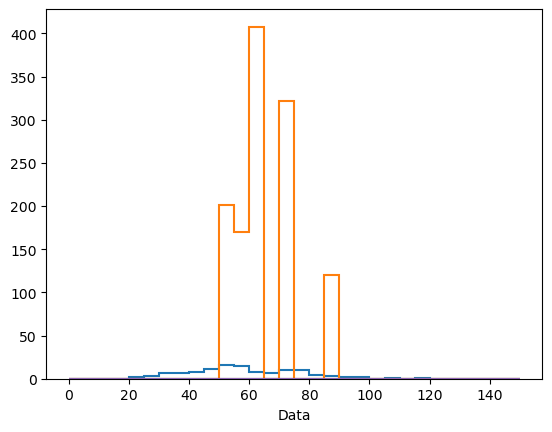

In [14]:
mt_results_local["Data"]["mass"].plot()
mt_results_local["DYJets"]["mass"].plot()
mt_results_local["WJets"]["mass"].plot()
mt_results_local["TT"]["mass"].plot()
mt_results_local["VV"]["mass"].plot()

Data_h, Data_bins = mt_results_local["Data"]["mass"].to_numpy()

In [22]:
d = {}
bins = np.linspace(0,150,30)

QCDScaleFactor = 1.6996559936491136

d["Data_h"], d["Data_bins"] = mt_results_local["Data"]["mass"].to_numpy()
d["Data_SS_h"], d["Data_SS_bins"] = mt_results_local["Data"]["ss_mass"].to_numpy()
labels1 = ["DYJets", "WJets", "TT", "VV"]
for i in labels1:
    d[i + "_h"], d[i + "_bins"] =  mt_results_local[i]["mass"].to_numpy()
    d[i + "_SS_h"], d[i + "_SS_bins"] =  mt_results_local[i]["ss_mass"].to_numpy()

d["QCD_h"] = np.subtract(np.subtract(np.subtract(d["Data_SS_h"], d["DYJets_SS_h"], dtype=object, out=None), d["WJets_SS_h"], dtype=object, out=None), d["TT_SS_h"], dtype=object, out=None)
for i in range(d["QCD_h"].size):
    if d["QCD_h"][i] < 0.0:
        d["QCD_h"][i] = 0.0
    d["QCD_w"] = np.full(shape=d["QCD_h"].shape, fill_value=QCDScaleFactor, dtype=np.double)
    d["QCD_hist"] = (d["QCD_h"], d["Data_SS_bins"])


In [23]:
outFile = uproot.recreate("boostedHTT_mt_2018_local.input.root")
outFile["DYJets_met_1_13TeV/data_obs"] = mt_results_local["Data"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/QCD"] = d["QCD_hist"]
outFile["DYJets_met_1_13TeV/WJets"] = mt_results_local["WJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/DYJets125"] = mt_results_local["DYJets"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/TT"] = mt_results_local["TT"]["mass"].to_numpy()
outFile["DYJets_met_1_13TeV/VV"] = mt_results_local["VV"]["mass"].to_numpy()
outFile.close()

In [ ]:
outFile = uproot.recreate("boostedHTT_mt_2018.input.root")


